# TimeGPT

In this notebook, we fine-tune TimeGPT, a `sequence-to-sequence` model,  to use last three years of Crop Sown-Area (`crop_area_ha`), Irrigated Area (`irrigated_area_ha`), Actual Rainfall (`actual_rainfall_mm`), Normal Rainfall (`normal_rainfall_mm`) data to predict `water_demand_m3`.

We load, clean, and preprocess the data before generating sequences for the model. We then create finetune TimeGPT and get the predictions. Later, we evaluate the model on the test set and generate metrics on the performance in terms of MAE (Mean Absolute Error), RMSE (Root Mean Square Error), and MAPE (Mean Absolute Percentage Error).

Finally, we generate synthetic drought scenarios by reducing the `actual_rainfall_mm` to a fraction of its original value and getting the impact on water demand.

## A. Data Preprocessing for TimeGPT

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

### 2. Data Cleanup

In [ ]:
DATAFILE_PATH = 'datafile.csv'

We load the data from the CSV file and rename the columns to the format expected by TimeGPT i.e. `time` and `target`.

We do not apply any scaling since TimeGPT handles that automatically.

In [3]:
df = pd.read_csv(DATAFILE_PATH)
df.columns = [c.strip() for c in df.columns]
dropped_cols = ['production_tonnes', 'yield_t_ha', 'irrigation_fraction']
df = df.drop(columns=dropped_cols)

# generate series id that will be used to differentiate
df["series_id"] = df["state"].str.replace(" ", "") + "_" + df["crop"]

df_long = df.rename(columns={
    "year": "time",
    "water_demand_m3": "target"
})
df_long["time"] = pd.to_datetime(df_long["time"], format="%Y")

# force values to be numeric
num_cols = [
    'crop_area_ha','irrigated_area_ha',
    'actual_rainfall_mm','normal_rainfall_mm',
    'cwr_m3_per_ha', 'target'
]
for c in num_cols:
    df_long[c] = pd.to_numeric(df_long[c], errors='coerce')

df_long = df_long.sort_values(by=["series_id", "time"]).reset_index(drop=True)

# rainfall anomaly
df_long['rainfall_anomaly_mm'] = df_long['actual_rainfall_mm'] - df_long['normal_rainfall_mm']

We remove the duplicate values by aggregating over the various parameters.

In [4]:
df_long = df_long.groupby(['state','time','crop'], as_index=False).agg({
    'crop_area_ha':'first',
    'irrigated_area_ha':'mean',
    'actual_rainfall_mm':'mean',
    'normal_rainfall_mm':'mean',
    'cwr_m3_per_ha':'mean',
    'target':'mean',
    'drought_flag':'max',
    'rainfall_anomaly_mm':'mean',
    'series_id':'first',
})

In [5]:
dropped_cols = ['state', 'crop']
df_long = df_long.drop(columns=dropped_cols)

### 3. Train - Test Split

Since TimeGpt expects series to have at least 25 observations (during training), we only keep those series that have at least 35 observations. The 10 buffer observations are kept since a train-test split will be performed, which will further reduce the number of training observations.

In [6]:
HORIZON = 5

In [7]:
# Count how many observations each series_id has
counts = df_long.groupby("series_id")["time"].count()

# Keep only series with >= 35 observations
valid_ids = counts[counts >= 35].index
df_long = df_long[df_long["series_id"].isin(valid_ids)].reset_index(drop=True)

print("Remaining series:", df_long["series_id"].nunique())
series_lengths = df_long.groupby("series_id").size()

Remaining series: 47


In [8]:
# Define split fractions
train_parts, test_parts = [], []
for sid, group in df_long.groupby("series_id"):
    train_parts.append(group.iloc[:-HORIZON])
    test_parts.append(group.iloc[-HORIZON:])

train_df = pd.concat(train_parts).reset_index(drop=True)
test_df  = pd.concat(test_parts).reset_index(drop=True)

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")

Train shape: (2400, 10), Test shape: (235, 10)


## B. Fine-tuning TimeGPT and obtaining predictions

### 1. Import Libraries

In [ ]:
%pip install nixtla

In [ ]:
from nixtla import NixtlaClient

import numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

load_dotenv()

### 2. Fine-tune the model

In [11]:
FEATURE_COLS = ["crop_area_ha", "irrigated_area_ha", "actual_rainfall_mm", "normal_rainfall_mm", "rainfall_anomaly_mm", "cwr_m3_per_ha", "drought_flag"]
CUSTOM_MODEL = "my-custom_water_demand_model"

In [12]:
# ENSURE THAT YOUR NIXTLA API KEY IS EITHER EXPORTED AS AN ENVIRONMENT VARIABLE
# OR THAT YOU HAVE A .env FILE CONTAINING YOUR API KEY
nixtla = NixtlaClient()

nixtla.finetune(
    df=train_df,
    freq='YS',
    finetune_steps=10,
    finetune_loss='mae',
    finetune_depth=2,
    time_col='time',
    target_col='target',
    id_col='series_id',
    model='timegpt-1',
    output_model_id=CUSTOM_MODEL
)

'my-custom_water_demand_model'

### 3. Get Predictions from the Model

The `hist_exog_list` contains the features that are used by the model to predict the target. The model conditions on these features and then generates its predictions.

In [13]:
fcst = nixtla.forecast(
    df=train_df,
    freq='YS',
    h=HORIZON,
    time_col="time",
    target_col="target",
    id_col="series_id",
    hist_exog_list=FEATURE_COLS,
    finetuned_model_id=CUSTOM_MODEL
)

## C. TimeGPT Performance Evaluation

### 1. Prepare Test Set

The evaluation set is generated by performing an operation similar to SQL JOIN so that we can match the predictions to the respective `series_id` and `time`. These columns are used as the keys for the JOIN. Later, `target` and `TimeGPT` columns are extracted to calculate the metrics.

In [14]:
df_eval = pd.merge(
    test_df[['series_id','time','target']],
    fcst[['series_id','time','TimeGPT']],
    on=['series_id','time'],
    how='inner'
)

y_true = df_eval['target'].values
y_pred = df_eval['TimeGPT'].values

### 2. Compute Performance Metrics

We calculate the following metrics:

- MAE: Mean Absolute Error (in 1e9 m^3 units)
- RMSE: Root Mean Square Error (in 1e9 m^3 units)
- SMAPE: Symmetric Mean Absolute Percentage Error (in %)

In [15]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

print(f"MAE: {mae/1e6:.2f} (1e6 m^3)")
print(f"RMSE: {rmse/1e6:.2f} (1e6 m^3)")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")

MAE: 1015.05 (1e6 m^3)
RMSE: 2000.11 (1e6 m^3)
MAPE: 27.97%
SMAPE: 18.42%


Finally we plot the predictions of the model against the actual values for the test set. A plot is generated for each `series_id` i.e. `state_crop` combination for the chosen horizon.

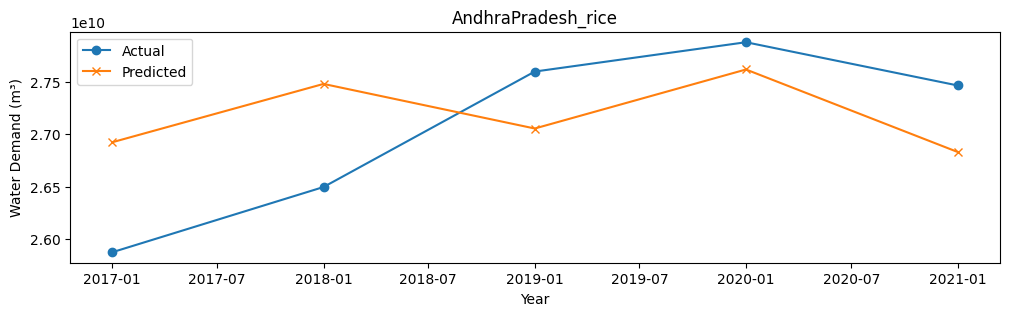

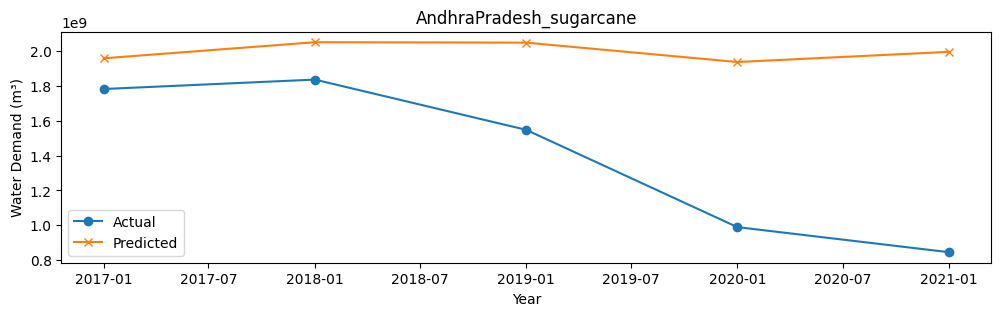

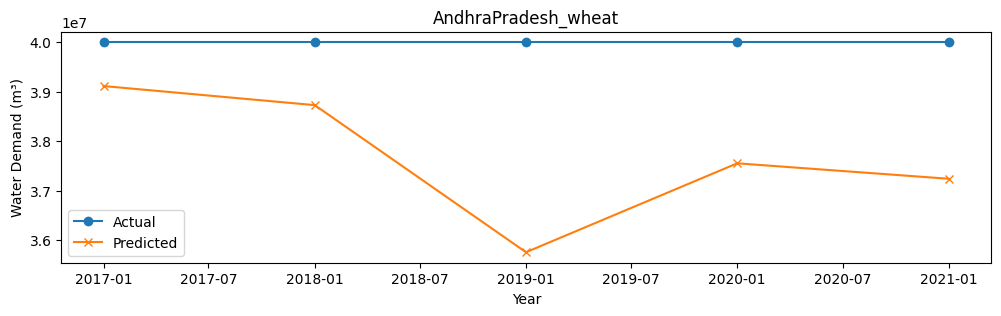

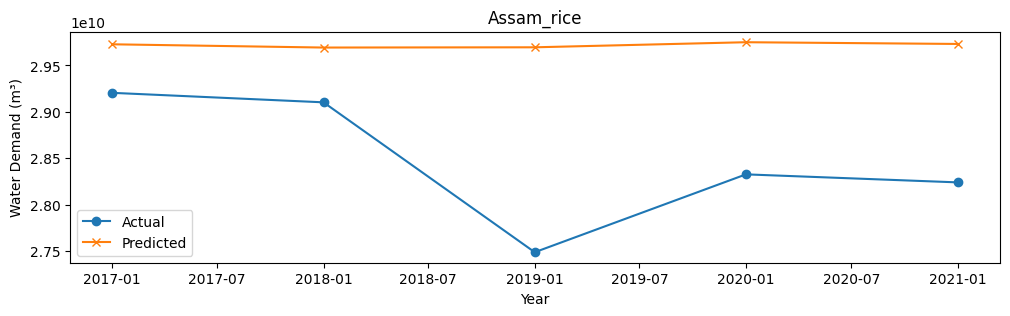

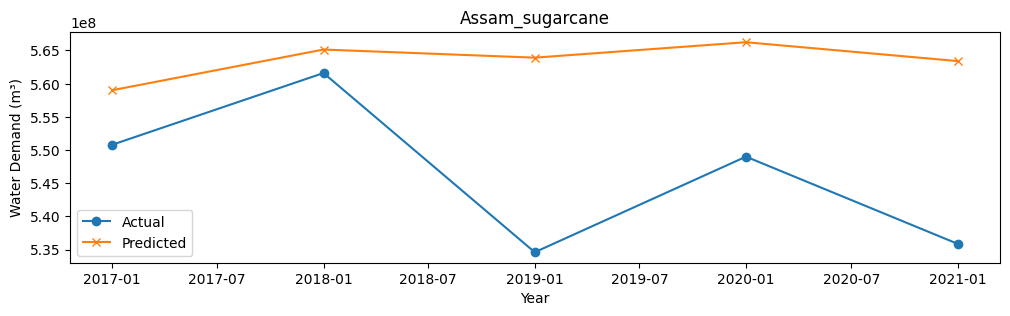

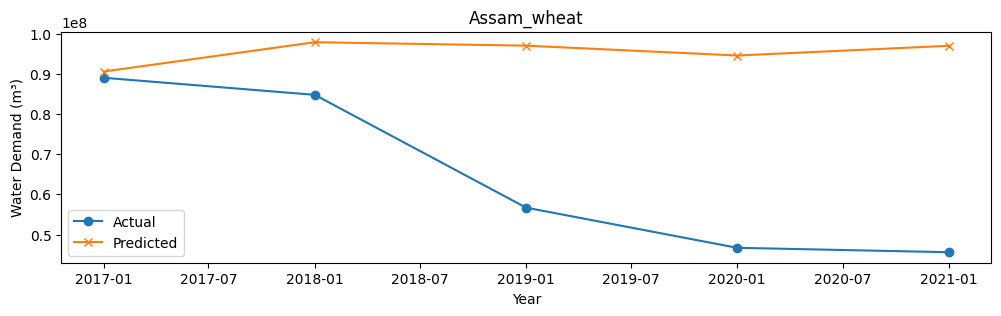

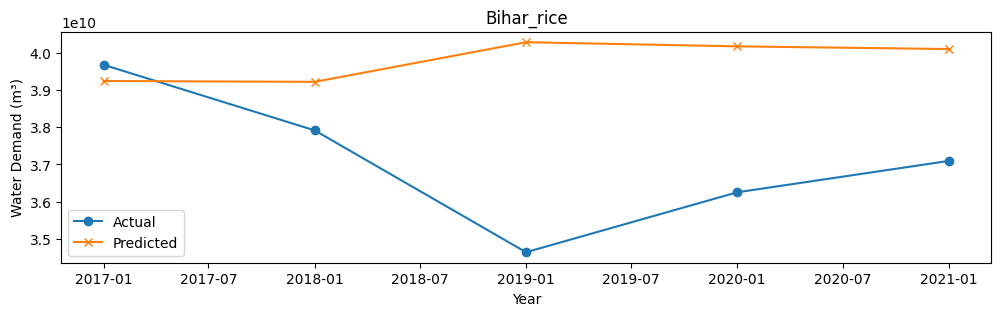

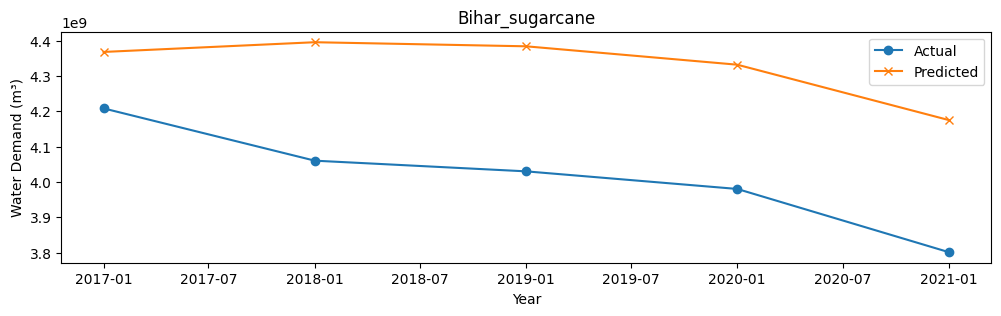

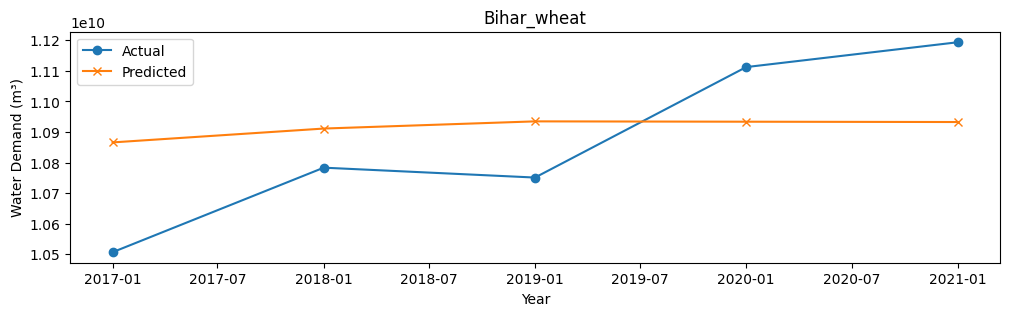

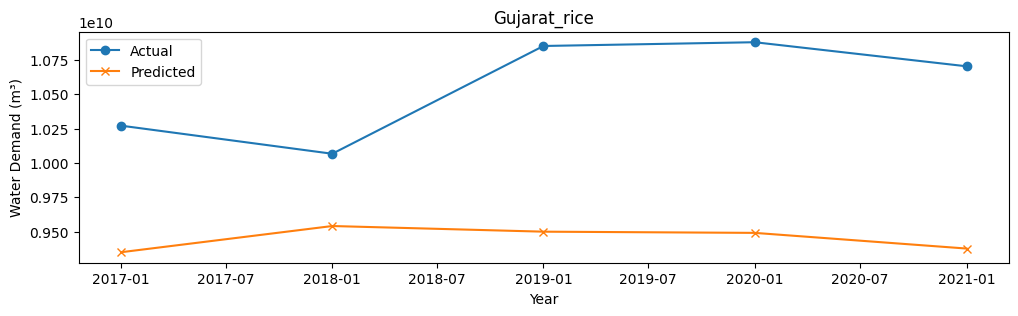

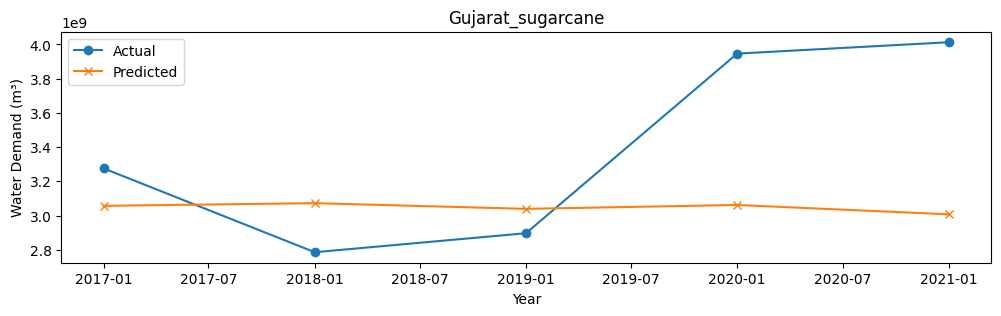

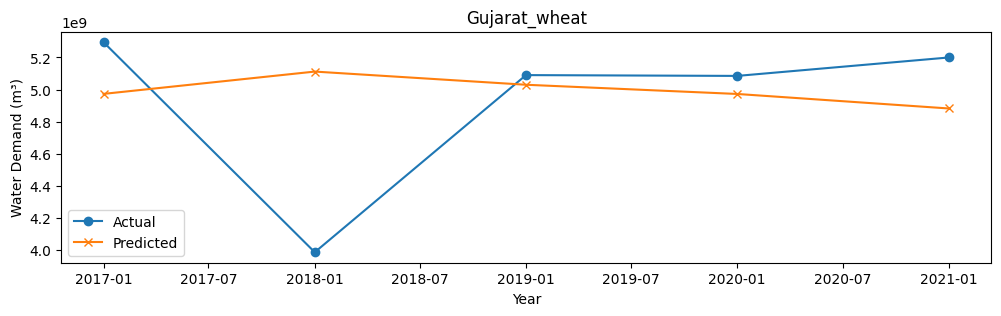

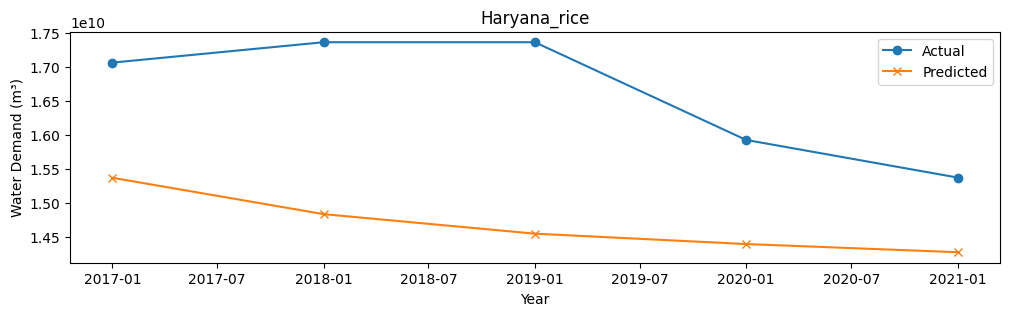

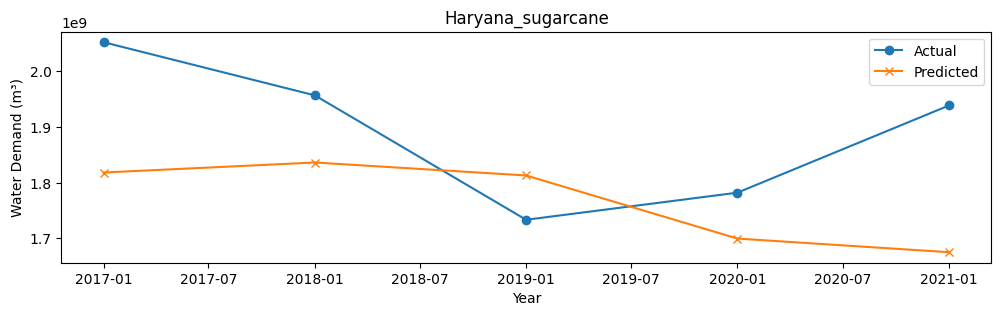

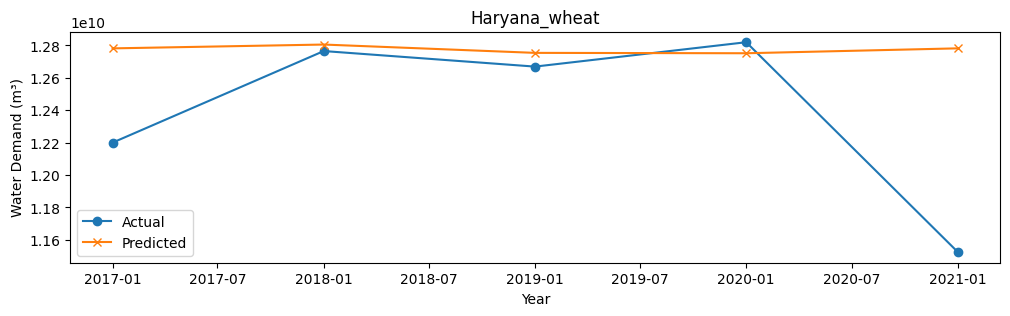

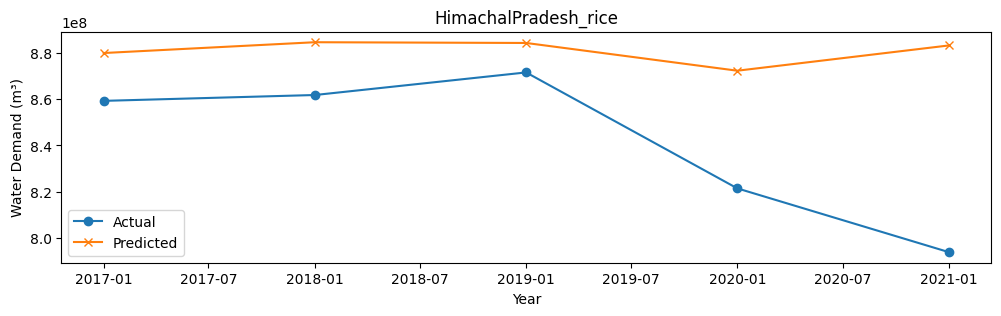

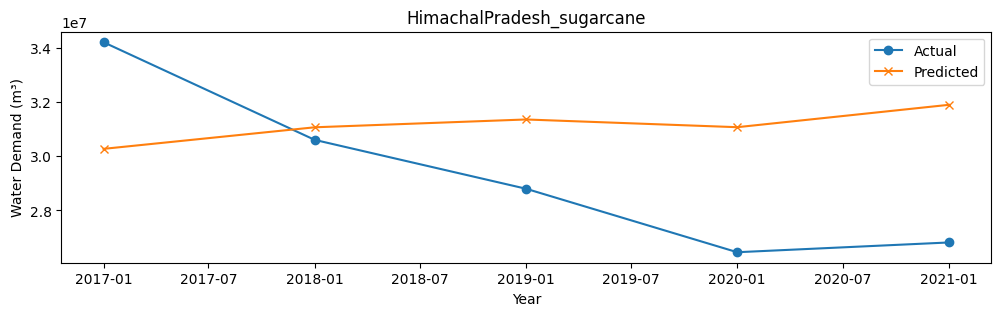

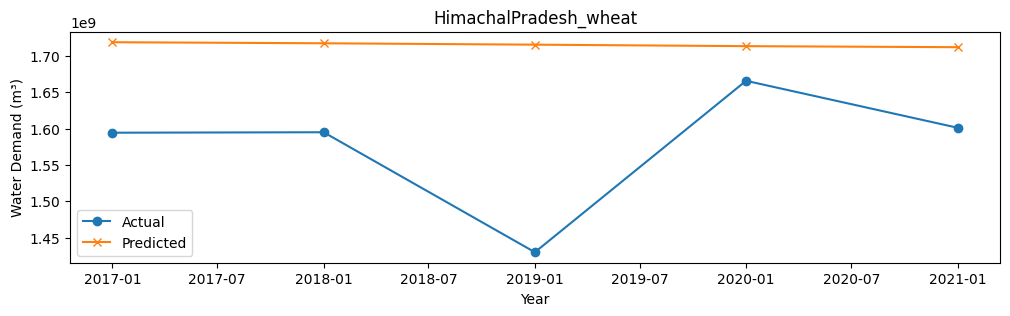

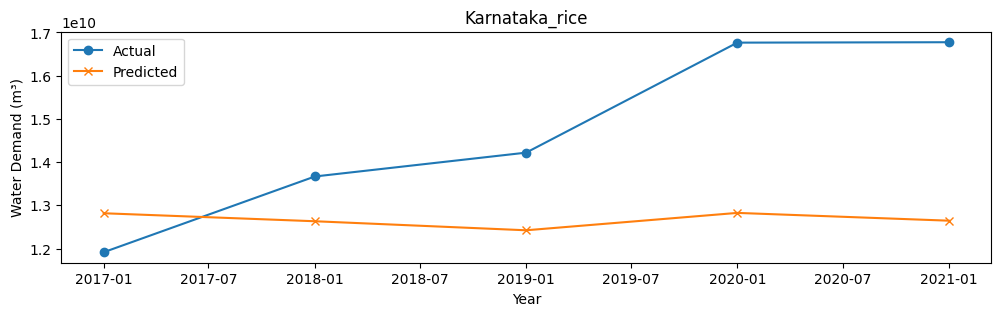

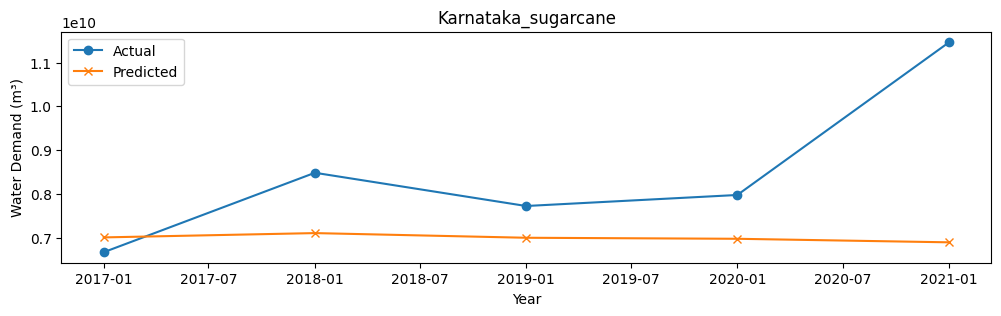

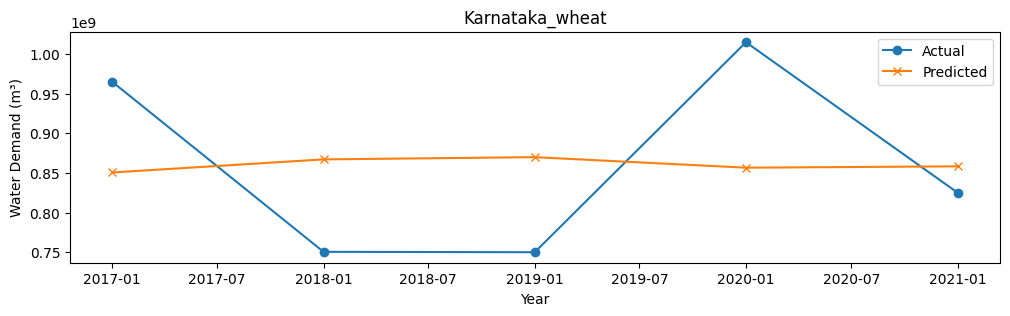

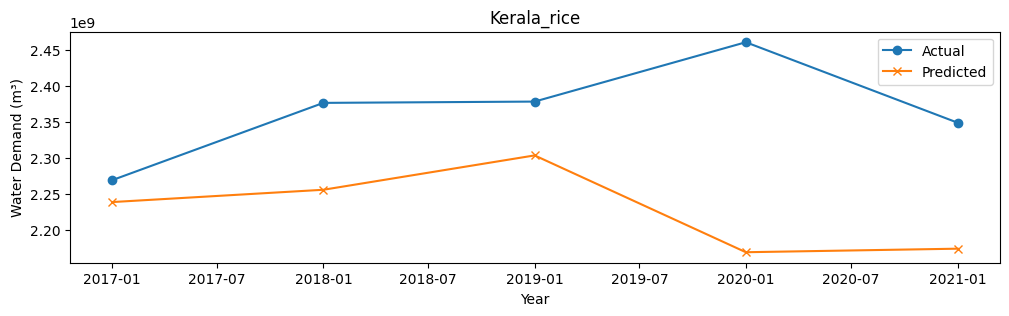

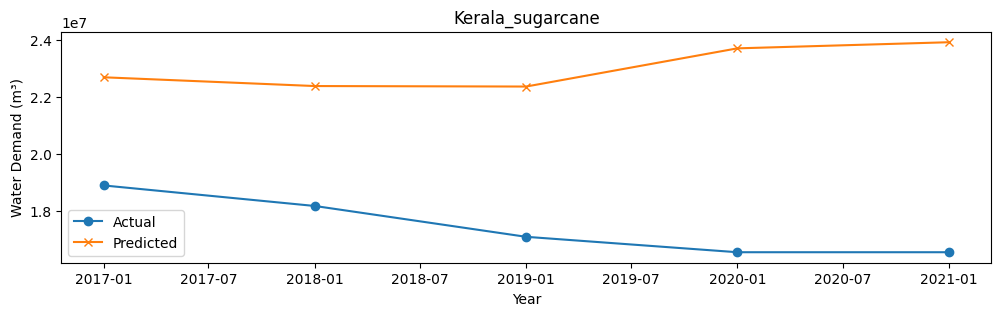

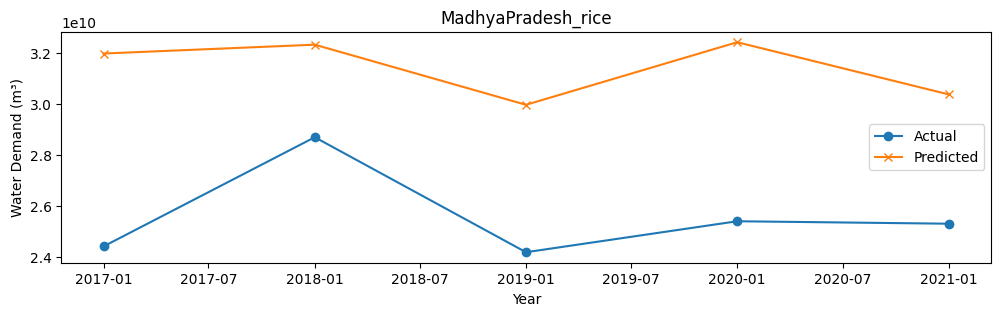

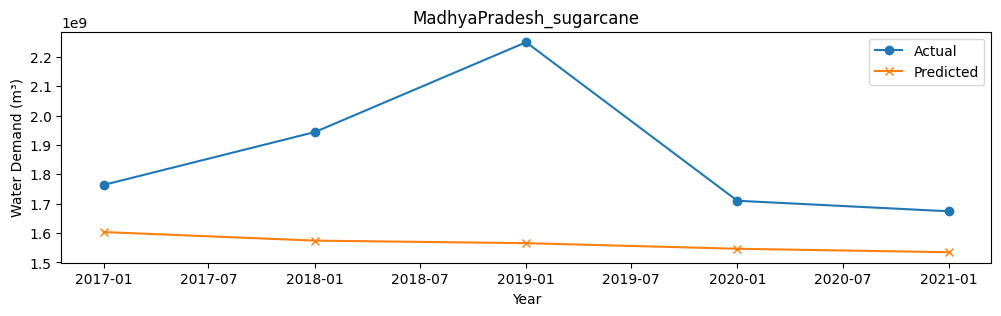

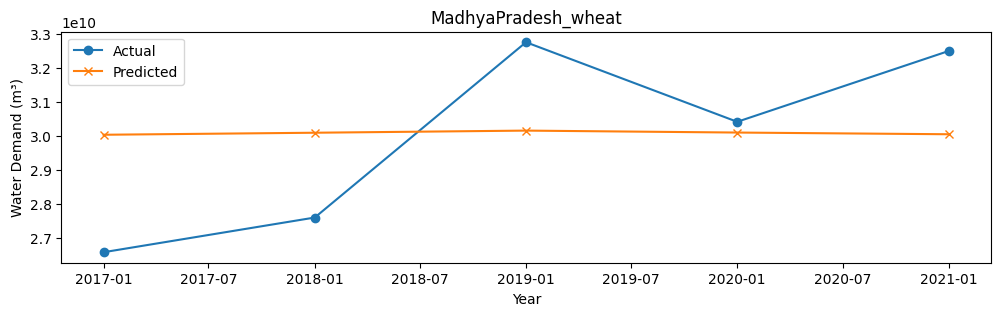

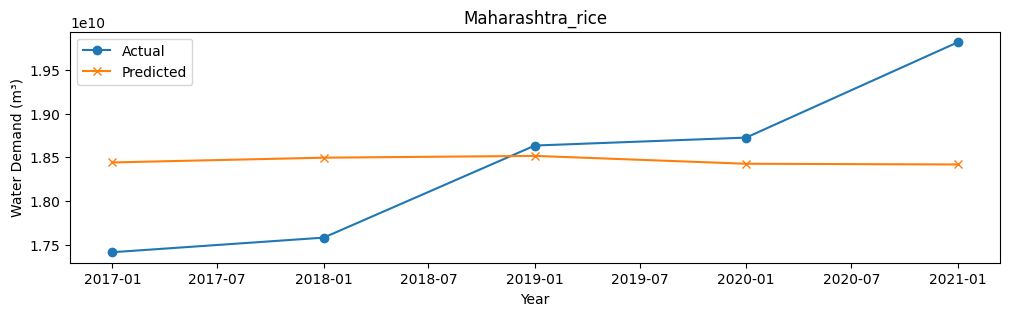

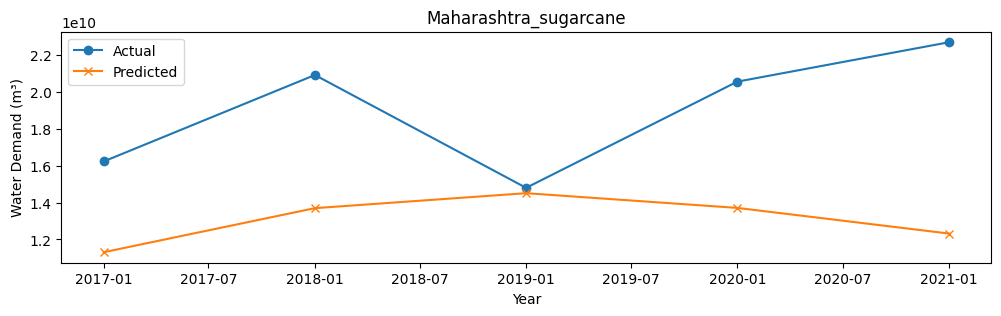

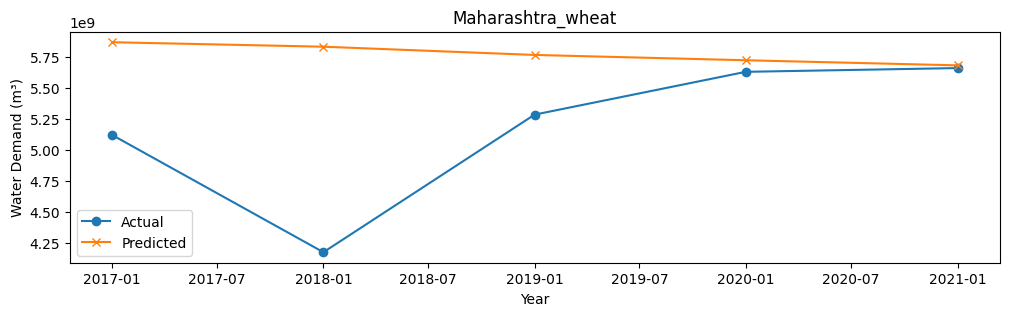

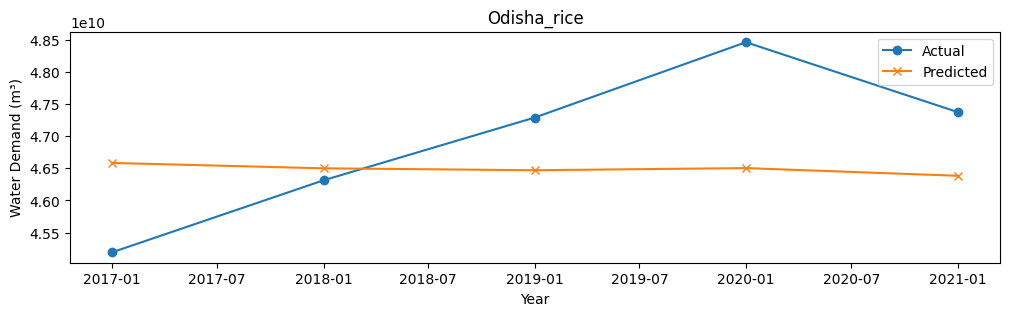

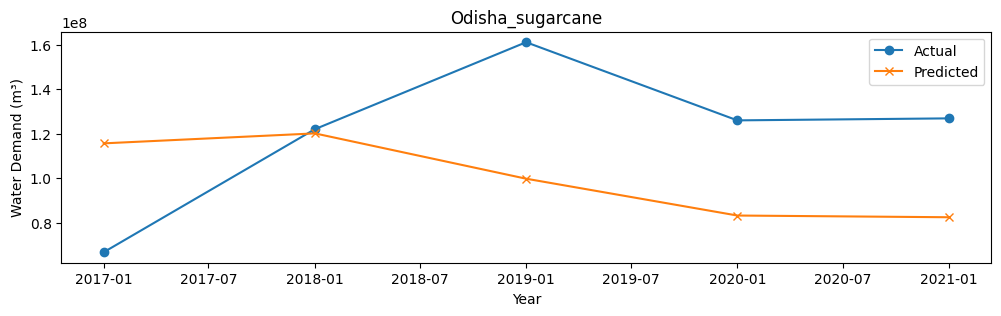

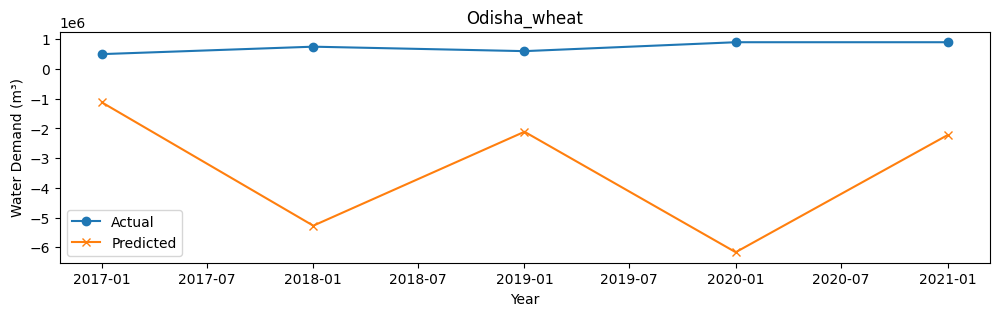

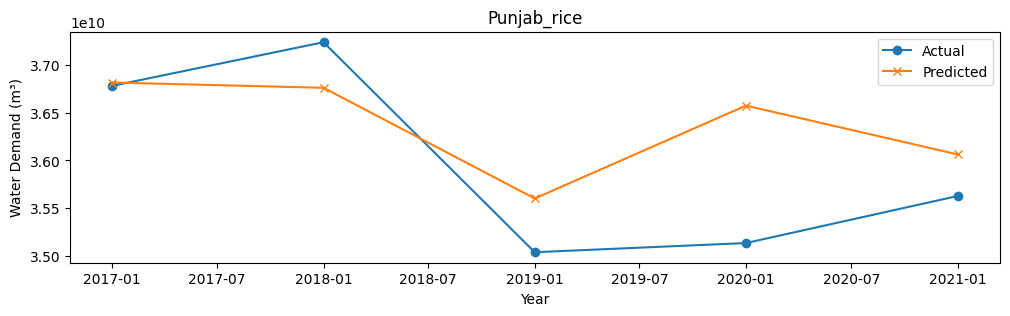

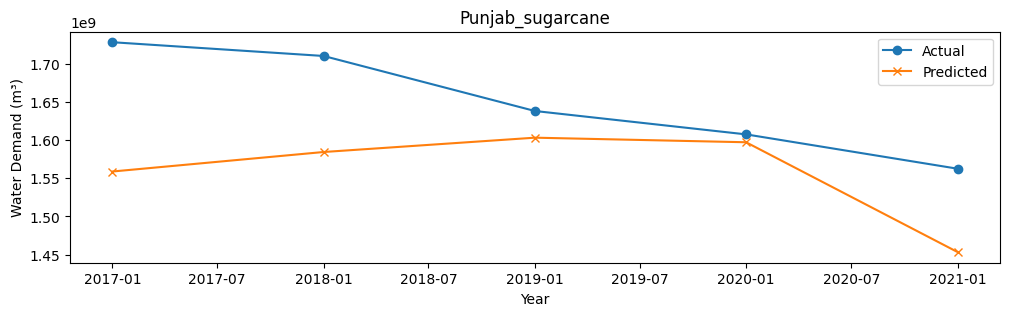

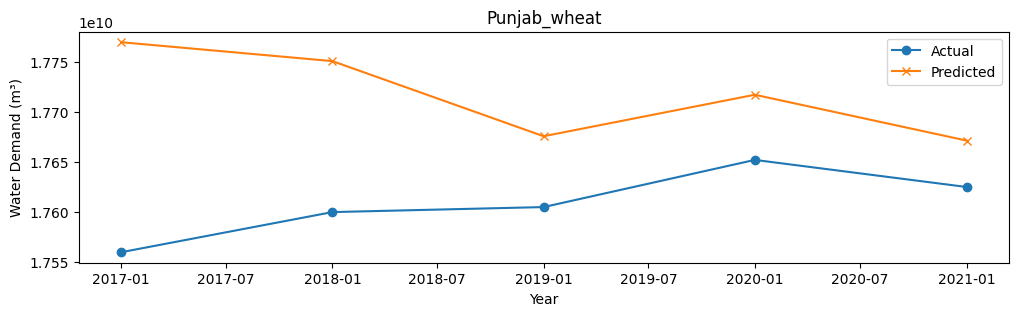

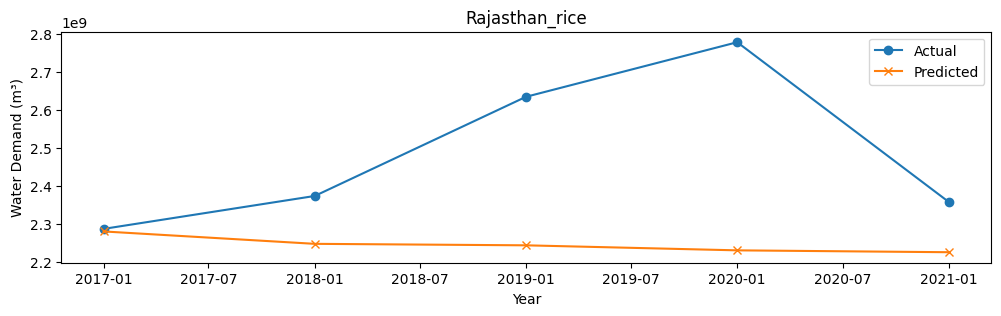

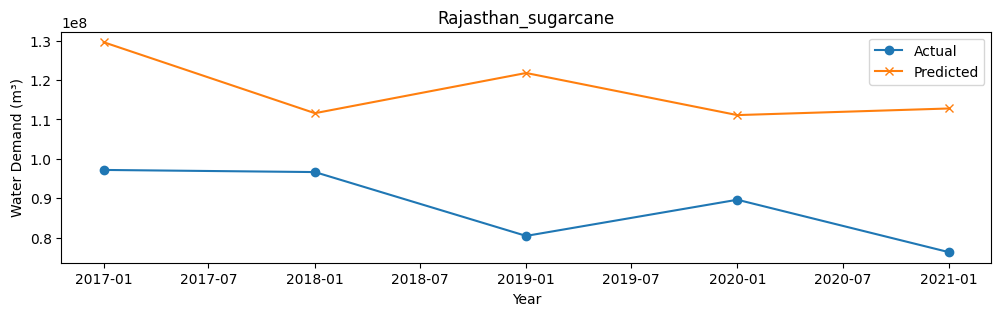

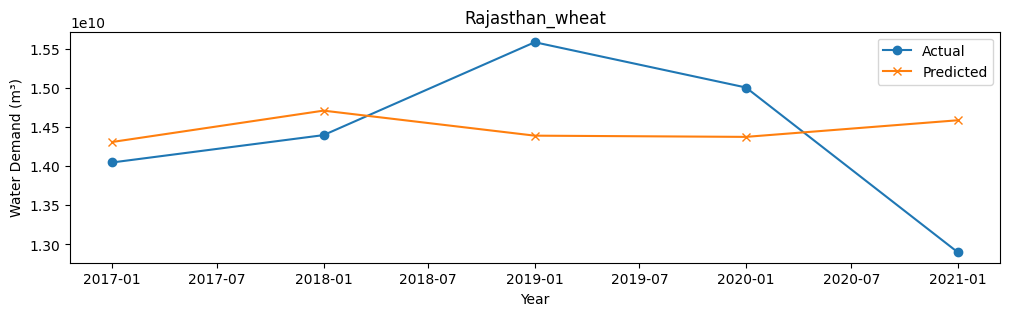

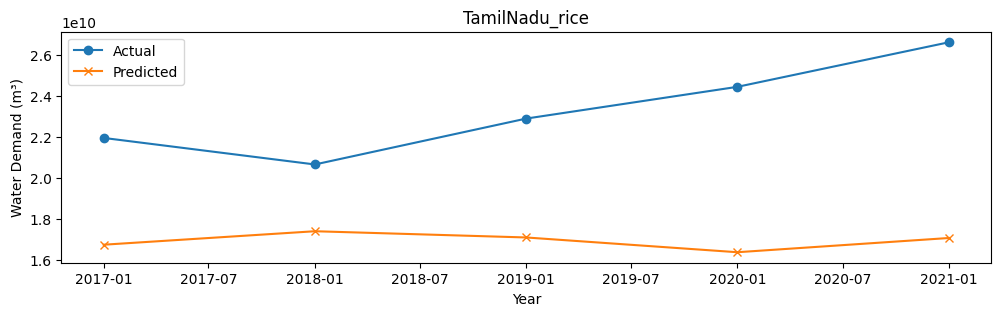

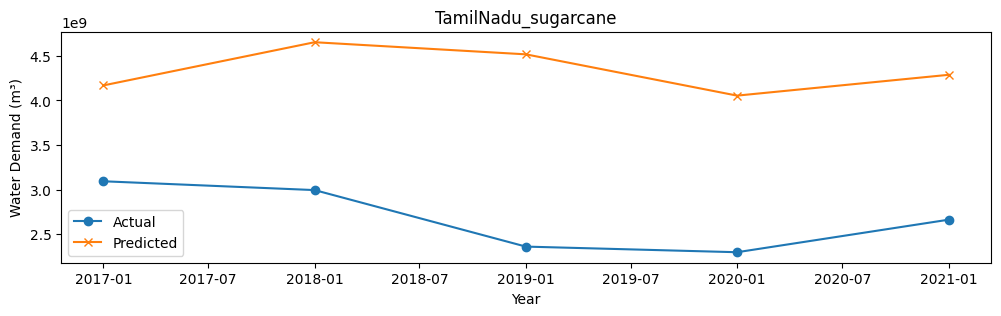

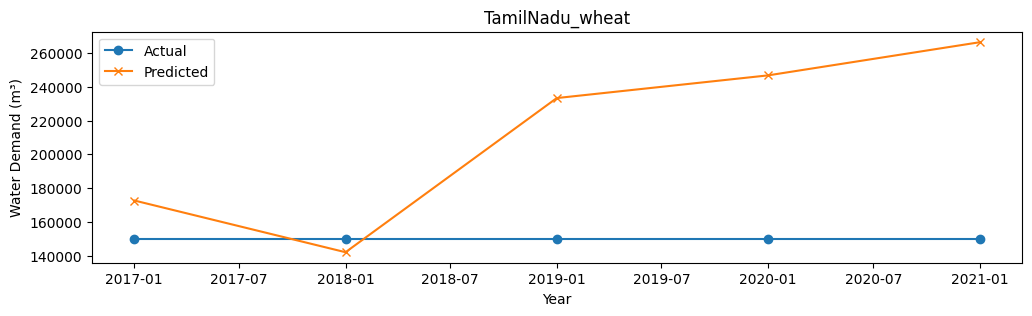

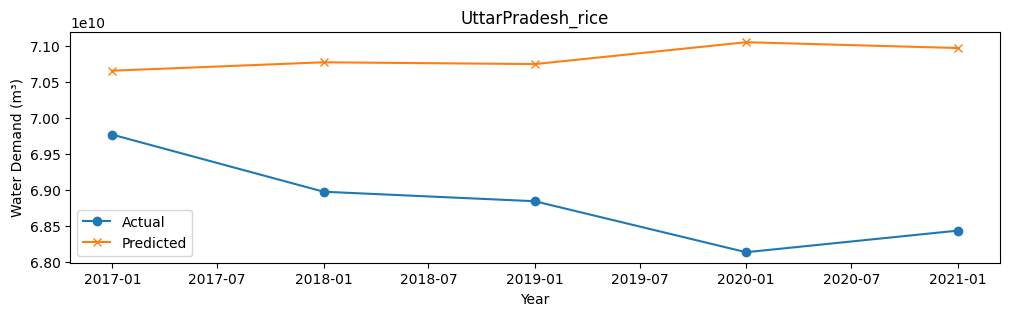

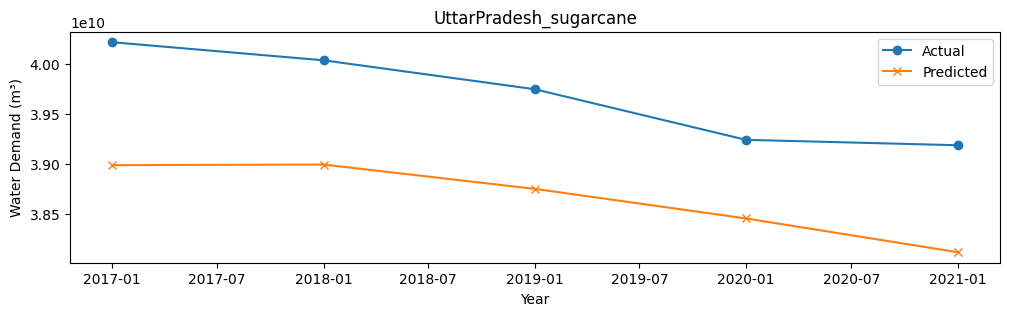

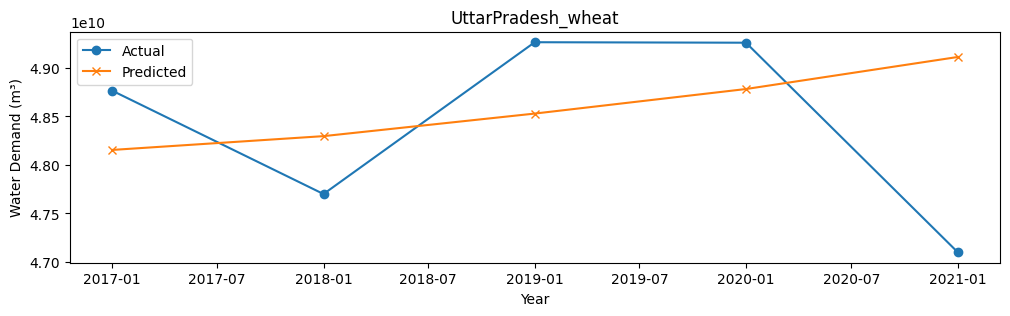

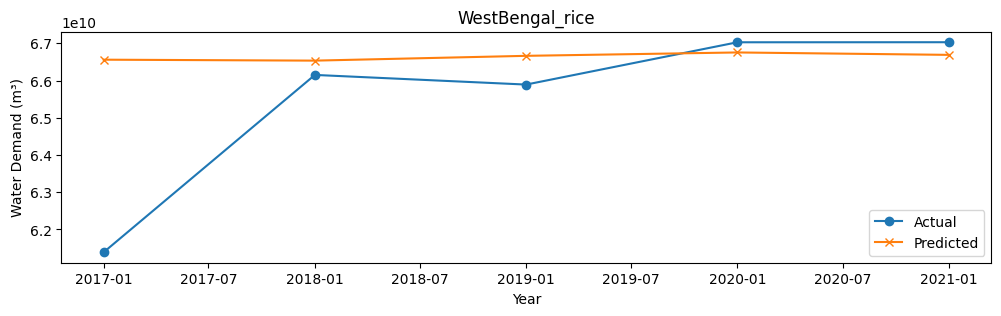

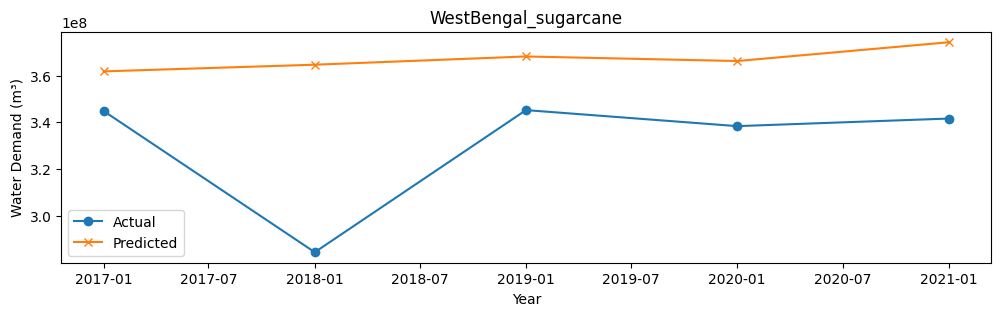

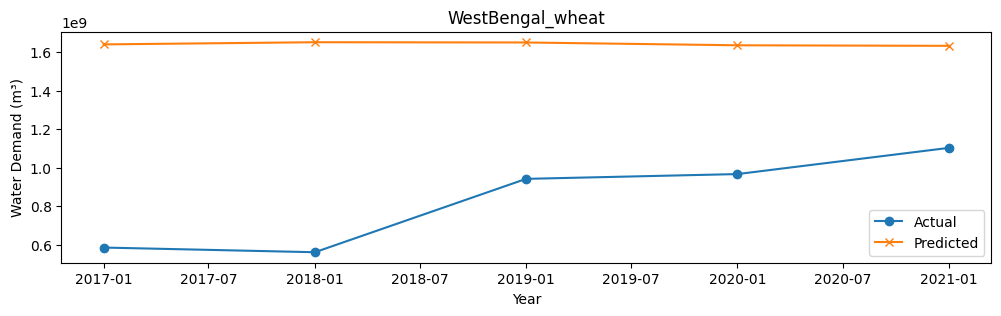

In [17]:
# -------------------------------
# Plot predictions
# -------------------------------
for sid in df_eval['series_id'].unique():
    temp = df_eval[df_eval['series_id']==sid]
    plt.figure(figsize=(12,3))
    plt.plot(temp['time'], temp['target'], marker='o', label='Actual')
    plt.plot(temp['time'], temp['TimeGPT'], marker='x', label='Predicted')
    plt.title(sid)
    plt.xlabel('Year')
    plt.ylabel('Water Demand (m³)')
    plt.legend()
    plt.show()

### 3. Drought-scenario Evaluation

We simulate drought / excess rainfall by varying the `actual_rainfall_mm` parameter and adjusting other parameters accordingly. We then ask the model to generate predictions for this new simulated condition.

In [18]:
RAINFALL_FACTOR = 0.5

In [19]:
train_df_drought = train_df.copy()

train_df_drought["actual_rainfall_mm"] *= RAINFALL_FACTOR
train_df_drought["rainfall_anomaly_mm"] = (
    train_df_drought["actual_rainfall_mm"] - train_df_drought["normal_rainfall_mm"]
)

# Explicitly set as int
train_df_drought["drought_flag"] = 1
train_df_drought["drought_flag"] = train_df_drought["drought_flag"].astype(int)

train_df_drought = train_df_drought.rename(columns={
    "year": "time",
    "water_demand_m3": "target"
})
train_df_drought["time"] = pd.to_datetime(train_df_drought["time"], format="%Y")

Get predictions from the model in the simulated conditions.

In [20]:
fcst_drought = nixtla.forecast(
    df=train_df_drought,
    freq='YS',
    h=HORIZON,
    time_col="time",
    target_col="target",
    id_col="series_id",
    hist_exog_list=FEATURE_COLS
)

Merge the dataframes and compare the result with baseline.

In [21]:
fcst = fcst.rename(columns={"TimeGPT": "Baseline"})
fcst_drought = fcst_drought.rename(columns={"TimeGPT": "Drought"})

df_eval_drought = pd.merge(
    fcst[['series_id','time','Baseline']],
    fcst_drought[['series_id','time','Drought']],
    on=['series_id','time'],
    how='inner'
)

df_eval_drought["Impact"] = df_eval_drought["Drought"] - df_eval_drought["Baseline"]
df_eval_drought["Percent_Change"] = (df_eval_drought["Impact"] / df_eval_drought["Baseline"]) * 100
scale = 1e9
df_eval_drought[["Baseline","Drought","Impact"]] /= scale

pd.set_option('display.float_format', lambda x: '%.2f' % x)
print("All absolute values are in 1e9 m^3 units\n")
display(df_eval_drought[:16])


All absolute values are in 1e9 m^3 units



,series_id,time,Baseline,Drought,Impact,Percent_Change
0,AndhraPradesh_rice,2017-01-01,26.92,27.24,0.32,1.17
1,AndhraPradesh_rice,2018-01-01,27.48,27.29,-0.19,-0.70
2,AndhraPradesh_rice,2019-01-01,27.06,26.98,-0.07,-0.27
3,AndhraPradesh_rice,2020-01-01,27.62,27.37,-0.26,-0.92
4,AndhraPradesh_rice,2021-01-01,26.83,26.76,-0.07,-0.27
5,AndhraPradesh_sugarcane,2017-01-01,1.96,1.97,0.01,0.36
6,AndhraPradesh_sugarcane,2018-01-01,2.05,2.11,0.06,2.71
7,AndhraPradesh_sugarcane,2019-01-01,2.05,2.07,0.02,1.19
8,AndhraPradesh_sugarcane,2020-01-01,1.94,1.89,-0.05,-2.53
9,AndhraPradesh_sugarcane,2021-01-01,2.00,2.04,0.04,2.01
